### Leaf Scan

### Importing the dependecies

In [2]:
import os
from os import listdir
import numpy as np
import cv2
import pickle
from tensorflow.keras.utils import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from PIL import Image
from keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
import matplotlib.pyplot as plt
from keras.optimizers import Adam

2024-04-06 12:10:50.092750: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Data Augmentation

In this part, applied data augmentation on the dataset to make dataset more diverse and to get more examples of each label.

In [ ]:
#Image Data Generator to get augmented pictures
datagen = ImageDataGenerator(
        rotation_range=90,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='nearest')


#Augmenting all the plants pictures

aug_directory = "Leaves/Apple"
images = listdir(aug_directory)

for image in images:
    i = 0
    image_directory = f"{aug_directory}/{image}"
    x = convert_image_to_array(image_directory)
    x = x.reshape((1,) + x.shape)
    for batch in datagen.flow(x,save_to_dir="Leaves/Apple", save_format='jpg'):
        i += 1
        if i > 1:
          break

### Fetching Images from Directory

In [82]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, (264,264))   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None
  

In [83]:
image_list, label_list = [], []

In [84]:
directory_root = "Leaves"
try:
    root_dir = listdir(directory_root)
    for directory in root_dir:
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir:          #Loading pictures in chunks due to session crashing
        plant_names_list = listdir(f"{directory_root}/{plant_folder}")
                
        for single_plant_image in plant_names_list :
            if single_plant_image == ".DS_Store" :
                plant_names_list.remove(single_plant_image)

        for image in plant_names_list:
            image_directory = f"{directory_root}/{plant_folder}/{image}"
            if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                image_list.append(convert_image_to_array(image_directory))
                label_list.append(plant_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Image loading completed


In [85]:
image_list = np.array(image_list)
print(len(image_list))
print(type(image_list))
label_list = np.array(label_list)
print(len(label_list))

7729
<class 'numpy.ndarray'>
7729


###  Visualizing the class distribution

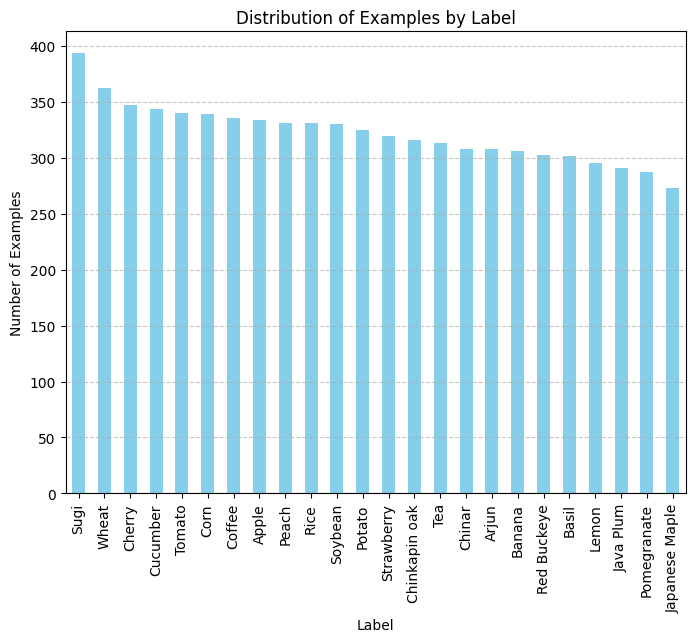

In [86]:
import pandas as pd
dataframe = pd.DataFrame(columns = ['labels'])
dataframe['labels'] = label_list
counts = dataframe['labels'].value_counts()

plt.figure(figsize=(8, 6))
counts.plot(kind='bar', color='skyblue')
plt.xlabel('Label')
plt.ylabel('Number of Examples')
plt.title('Distribution of Examples by Label')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


The Plot above os showing the class distribution of all the classes have an average of 300 to 350 examples which shows that their is no imbalancing in our dataset.

### Transforming the Labels

Transforming string labels in to mathematical form to feed the labels into the model

In [87]:
binarizer = LabelBinarizer()
label_list = binarizer.fit_transform(label_list)

# Save the label binarizer to a file
'''with open('label_binarizer.pkl', 'wb') as f:
    pickle.dump(binarizer, f)'''

print("Transformed Label: ",label_list[7711])

print("Images Shape: ",image_list[0].shape)

Transformed Label:  [0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0]
Images Shape:  (264, 264, 3)


In [88]:
print(binarizer.classes_)
print(len(image_list))
print(len(label_list))



['Apple' 'Arjun' 'Banana' 'Basil' 'Cherry' 'Chinar' 'Chinkapin oak'
 'Coffee' 'Corn' 'Cucumber' 'Japanese Maple' 'Java Plum' 'Lemon' 'Peach'
 'Pomegranate' 'Potato' 'Red Buckeye' 'Rice' 'Soybean' 'Strawberry' 'Sugi'
 'Tea' 'Tomato' 'Wheat']
7729
7729


In [89]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0

### Splitting the Dataset

In [90]:
x_train, x_test, y_train, y_test = train_test_split(np_image_list, label_list, test_size=0.2, random_state = 42)

In [ ]:
def calculate_class_weights(y):
    unique_classes = [list(x) for x in set(tuple(x) for x in y)]
    class_counts = counts
    total_samples = len(y)
    class_weights = {}

    for class_label, class_count in zip(unique_classes, class_counts):
        print(class_label)
        print(class_count)
        class_weight = total_samples / (2.0 * class_count)
        class_weights[class_label] = class_weight

    return class_weights

class_weights = calculate_class_weights(y_train)
print("Class weights:", class_weights)

### Modelling


In this part, Designed the CNN model. Performed batch normalization after each covolutional layer and use maxpooling layers as well.

In [96]:
depth = 3
height,width = 264,264
inputshape = (264,264,3)
n_classes = 24
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1

model = Sequential()


model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputshape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

In [97]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 264, 264, 32)      896       
                                                                 
 activation_14 (Activation)  (None, 264, 264, 32)      0         
                                                                 
 batch_normalization_12 (Bat  (None, 264, 264, 32)     128       
 chNormalization)                                                
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 88, 88, 32)       0         
 2D)                                                             
                                                                 
 dropout_8 (Dropout)         (None, 88, 88, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 88, 88, 64)       

Provided the learning rate(0.001) which helps model to minimize errors and used adam optimizer with binary crossentropy loss function

In [98]:
INIT_LR = 0.001
opt = Adam(lr=INIT_LR, decay=INIT_LR / 25)
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])

In [99]:
history = model.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=12, verbose=1, 
    )

Epoch 1/12
194/194 [==============================] - 921s 5s/step - loss: 0.4055 - accuracy: 0.2711 - val_loss: 0.1923 - val_accuracy: 0.1003
Epoch 2/12
194/194 [==============================] - 907s 5s/step - loss: 0.0979 - accuracy: 0.6248 - val_loss: 0.1941 - val_accuracy: 0.2361
Epoch 3/12
194/194 [==============================] - 901s 5s/step - loss: 0.0660 - accuracy: 0.7614 - val_loss: 0.0949 - val_accuracy: 0.5750
Epoch 4/12
194/194 [==============================] - 882s 5s/step - loss: 0.0507 - accuracy: 0.8237 - val_loss: 0.0404 - val_accuracy: 0.8325
Epoch 5/12
194/194 [==============================] - 873s 4s/step - loss: 0.0400 - accuracy: 0.8628 - val_loss: 0.0420 - val_accuracy: 0.8292
Epoch 6/12
194/194 [==============================] - 860s 4s/step - loss: 0.0322 - accuracy: 0.9002 - val_loss: 0.0676 - val_accuracy: 0.7225
Epoch 7/12
194/194 [==============================] - 861s 4s/step - loss: 0.0280 - accuracy: 0.9154 - val_loss: 0.0319 - val_accuracy: 0.8816

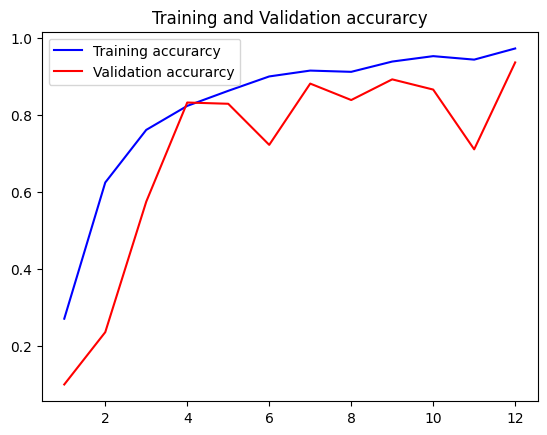

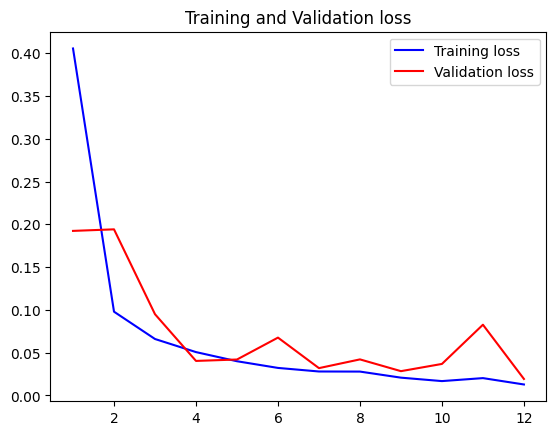

In [100]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

The plots above shows the training and validation loss of the model 

Now Performing accuracy test on test dataset to show the accuracy of the model

In [101]:
print("Model Accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

Model Accuracy
49/49 [==============================] - 52s 1s/step - loss: 0.0193 - accuracy: 0.9366
Test Accuracy: 93.66105794906616


In [103]:
model_predictions = model.predict(x_test)

49/49 [==============================] - 49s 970ms/step


### Confusion Matrix

In [ ]:
from sklearn.metrics import confusion_matrix

predicted_class_label = binarizer.inverse_transform(model_predictions)
y_test = binarizer.inverse_transform(y_test)

In [ ]:
matrix = confusion_matrix(y_test, predicted_class_label)
print(matrix)

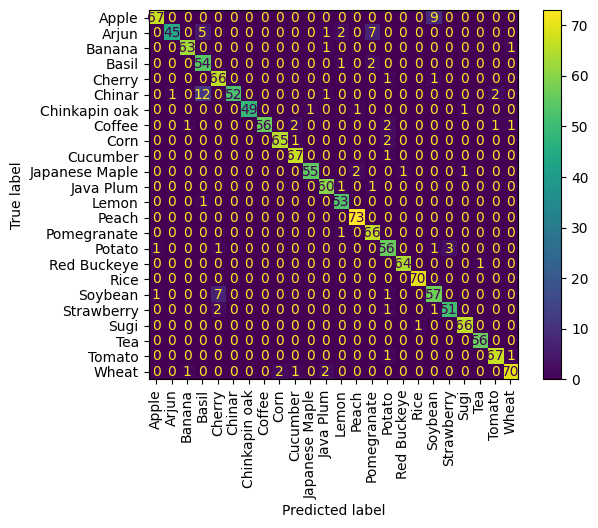

In [112]:
from sklearn.metrics import ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=matrix,display_labels=binarizer.classes_)
disp.plot(xticks_rotation='vertical')
plt.show()

The above is plot is showing the confusion matrix of the model which shows how many examples of each label does the model guessed right.

Text(0, 0.5, 'Fraction classified incorrectly')

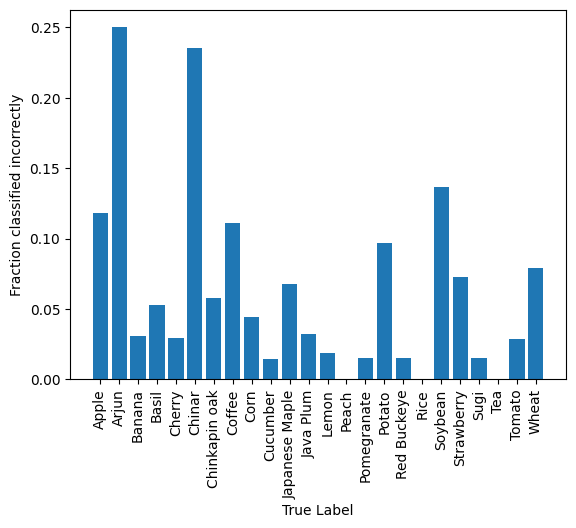

In [130]:
label_frac_error = 1 - np.diag(matrix) / np.sum(matrix, axis=1)
plt.bar(binarizer.classes_,label_frac_error)
plt.xlabel('True Label')
plt.xticks(rotation = 90)
plt.ylabel('Fraction classified incorrectly')

The above plot is showing the percentage or fraction of classes that are predicted incorrect by the model

In [113]:
pickle.dump(model, open('model.pkl', 'wb'))

In [114]:
pickle.dump(binarizer,open('binarizer.pkl','wb'))

In [115]:
model.save('model.h5')